In [1]:
from tensorflow.keras import optimizers
from cifar.cifar_capsnet import CapsNetCifar
from utils.utils import plot_log
from metrics import margin_loss

ROUTINGS = 3
BATCH_SIZE = 100
INPUT_SHAPE = (32, 32, 3)

model, eval_model, manipulate_model = CapsNetCifar(input_shape=INPUT_SHAPE,
                                                  n_class=10,
                                                  routings=ROUTINGS,
                                                  batch_size=BATCH_SIZE)

lr = 0.001
lam_recon = 0.392
# compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                loss=[margin_loss, 'mse'],
                loss_weights=[1., lam_recon],
                metrics={'capsnet': 'accuracy'})

save_dir='./result/capsnet_cifar/capsnet_triplet_modif-05-16'
weights = './result/capsnet_cifar/capsnet_cifar_modif-05-15/trained_model.h5'
model.load_weights(weights)

# plot_log(save_dir + '/log.csv', show=True)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
starting CapsNetCifar (32, 32, 3) 10 3 100


In [2]:
from tensorflow.keras import layers, models, optimizers

input_a = layers.Input(name="anchor", shape=INPUT_SHAPE)
input_p = layers.Input(name="positive", shape=INPUT_SHAPE)
input_n = layers.Input(name="negative", shape=INPUT_SHAPE)

embedding_a = eval_model(input_a)
embedding_p = eval_model(input_p)
embedding_n = eval_model(input_n)

output = layers.concatenate([embedding_a, embedding_p, embedding_n], axis=1)
# print(output)

siamese_net = models.Model([input_a, input_p, input_n], output)
siamese_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (100, 32, 32, 3)     6707712     anchor[0][0]                     
                                                                 positive[0][0]             

In [3]:
import tensorflow as tf
import numpy as np
from images import create_batch, images_train, images_valid
from metrics import get_callbacks, emb_size, alpha


def accuracy(y_true, y_pred):
    # y_pred shape [100, 96, 32, 3]
    anchor, positive, negative = y_pred[:, :emb_size], y_pred[:,
                                                              emb_size:2*emb_size], y_pred[:, 2*emb_size:]
    # tf.print(anchor.shape)
    # anchor shape [100, 32, 32, 3]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    # tf.print(positive_dist.shape)
    # positive_dist = tf.reduce_sum(positive_dist, axis=1)
    # negative_dist = tf.reduce_sum(negative_dist, axis=1)
    # positive_dist = tf.reduce_sum(positive_dist, axis=1)
    # negative_dist = tf.reduce_sum(negative_dist, axis=1)
    # tf.print(positive_dist.shape)
    # tf.print(negative_dist)
    return positive_dist + 0.2 < negative_dist

# def calc_pd(y_true, y_pred):


def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:, :emb_size], y_pred[:,
                                                              emb_size:2*emb_size], y_pred[:, 2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    L = tf.maximum(positive_dist - negative_dist + alpha, 0.)
    # tf.print(L)
    return L


def data_generator(images):
    while True:
        x = create_batch(images, INPUT_SHAPE)
        y = np.zeros((100, 3*emb_size))
        yield [x[0], x[1], x[2]], y

# data_generator().send(None)[0][0].shape

lr = 0.00006
net_callbacks = get_callbacks(save_dir, lr, 0.9, 'val_accuracy')
optimiser_obj = optimizers.Adam(learning_rate=lr)
siamese_net.compile(loss=triplet_loss, optimizer=optimiser_obj,
                    metrics=[accuracy])
run_fit = False

if(run_fit):
    siamese_net.fit(
        data_generator(images_train),
        steps_per_epoch=int(len(images_train)/BATCH_SIZE),
        epochs=10,
        validation_data=data_generator(images_valid),
        validation_steps=int(len(images_valid)/BATCH_SIZE),
        callbacks=[net_callbacks])

    siamese_net.save_weights(save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)
else:
    siamese_net.load_weights(save_dir + '/trained_model.h5')
# plot_log(save_dir + '/log.csv', show=True)

c:\Users\Tautvydas\Documents\magistras\master_capsnet\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0-rc2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [4]:
from images import preprocess_image_with_angle, images_test
# get 100 test images
# images_test_eval = []
x_a = np.zeros((BATCH_SIZE, *INPUT_SHAPE))  # * - expands tuple
x_p = np.zeros((BATCH_SIZE, *INPUT_SHAPE))  # * - expands tuple
x_n = np.zeros((BATCH_SIZE, *INPUT_SHAPE))  # * - expands tuple
for i in range(10):
    for angle in range(10):
        image_a = preprocess_image_with_angle(
            images_test[i*3], angle, 10)
        image_p = preprocess_image_with_angle(
            images_test[i*3+1], 0, 10)
        image_n = preprocess_image_with_angle(
            images_test[i*3+2], 0, 10)
        x_a[i*10 + angle] = image_a
        x_p[i*10 + angle] = image_p
        x_n[i*10 + angle] = image_n
images_test_eval = np.array([x_a, x_p, x_n])
print(images_test_eval.shape, len(images_test))

(3, 100, 32, 32, 3) 30


In [5]:
from keras.preprocessing.image import ImageDataGenerator
# print(np.mean(x_a[0]), np.mean(x_p[0]), np.mean(x_n[0]))
# print(np.nansum(x_a[1]), np.nansum(x_p[1]), np.nansum(x_n[1]))
# print(1/(32*32*3) * np.nansum(x_a[1]), 1/(32*32*3) * np.nansum(x_p[1]))
# S = math.sqrt(1/(32*32*3-1) * np.nansum((x_a[0] - np.mean(x_a[0]))**2))
# # (x_a[0] - np.mean(x_a[0])) / S
# print(np.mean(images_test_eval), np.mean(x_a), np.mean(x_p), np.mean(x_n))
# def normal(x_ar):
#     return np.mean((x_ar - np.min(x_ar)) / (np.max(x_ar) - np.min(x_ar)))
# print(normal(x_a[42]))
# print(normal(x_p[42]))
# print(normal(x_n[42]))

# x_im = x_a[70]
# means = x_im.mean(axis=(0,1), dtype='float64')
# std = x_im.std(axis=(0,1), dtype='float64')
# print(means, std)
# x_a0 = (x_im - means) / std
# print(x_a0.mean(), x_a0.std(), x_a0.max(), x_a0.min())
# x_a0 = (x_a0 - x_a0.min()) / (x_a0.max() - x_a0.min())
# print(x_a0.mean(), x_a0.std(), x_a0.max(), x_a0.min())

[0.49432177 0.49342406 0.49356684] [0.10197488 0.10605859 0.10576443]
0.0 1.0000000000000002 2.8128069710455614 -3.300285378280451
0.5398716704556766 0.16358332949284718 1.0 0.0


(100, 96, 32, 3) (100, 96, 32, 3)
Reconstructed images are saved to ./result/capsnet_cifar/capsnet_triplet_modif-05-16/triplet_recon.png
------------------------------End: test------------------------------


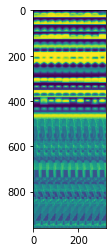

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import combine_images
file_name = "triplet_recon"
x_recon = siamese_net.predict([x_a, x_p, x_n], batch_size=100)
images_test_eval_x = np.concatenate(images_test_eval, axis=1)
print(x_recon.shape, images_test_eval_x.shape)
# img = combine_images(np.concatenate([x_recon[:3], x_recon[10:13]]))
img = combine_images(np.concatenate([x_recon[:50], images_test_eval_x[:50]]))
def print_combined_embeddings(image, save_dir, file_name):
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(
            save_dir + "/" + file_name + ".png")
    print('Reconstructed images are saved to %s/%s.png' %
            (save_dir, file_name))
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(save_dir + "/" + file_name + ".png"))
    plt.show()
print_combined_embeddings(img, save_dir, file_name)

In [7]:
import math
def combine_images3(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))
    print("width", width, "height", height)

    shape = generated_images.shape[1:3]
    print(shape)
    image = np.zeros((height*shape[0], width*shape[1], 3),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1], 0] = \
            img[:, :, 0]
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1], 1] = \
            img[:, :, 1]
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1], 2] = \
            img[:, :, 2]
    return image

# img = combine_images3(x_recon)
combined = np.concatenate([x_recon[:50], images_test_eval_x[:50]])
print(combined.shape)
img = combine_images3(combined)
print_combined_embeddings(img, save_dir, "triplet_recon_3c")

(100, 96, 32, 3)
width 10 height 10
(96, 32)
Reconstructed images are saved to ./result/capsnet_cifar/capsnet_triplet_modif-05-16/triplet_recon_3c.png
------------------------------End: test------------------------------


2.4537983 15.521568
2.8984165 18.95641
7.3127785 27.529297
4.1644444 22.670937
6.1596117 25.409256
2.4537983 15.521568
1.7116554 15.135414
4.082752 22.230276
3.0365453 18.545055
1.7000157 11.534206
6.1051555 28.591928
10.097292 33.69454
13.326605 35.758965
14.35331 35.68971
16.636303 36.447186
6.1051555 28.591928
6.456778 29.742739
9.275755 31.23149
4.5469117 27.021759
16.961767 35.82285
29.03023 39.921978
37.22223 45.319126
35.772125 44.674107
35.811672 44.27115
32.655113 41.086704
29.03023 39.921978
31.749153 41.60921
37.097805 45.037224
27.459406 38.539356
32.594765 42.08255
22.096735 36.15305
16.916029 39.85662
18.417868 38.893143
20.101408 36.990932
24.988857 36.829987
22.096735 36.15305
22.38873 35.404224
28.621862 33.116768
27.179035 32.979546
36.373566 27.21412
4.1978526 33.93592
24.06377 5.082472
5.443888 22.408134
15.233711 10.790242
12.429673 13.947857
4.1978526 33.93592
15.481638 12.150043
3.6783957 37.380993
3.938802 22.847954
12.267145 14.584199
36.861008 29.643772
38.252

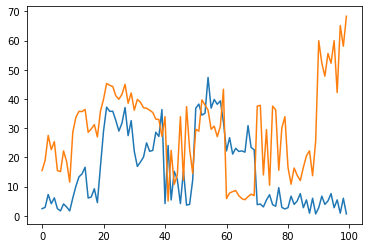

: 

In [8]:
tp = 0
fp = 0
xaxis = []
yaxis = []
for i in range(0, 100):
    embedding_img_a = x_recon[i, :32]
    embedding_img_p = x_recon[i, 32:64]
    embedding_img_n = x_recon[i, 64:]
    # embedding_img_a.shape, embedding_img_p.shape, embedding_img_n.shape
    p = np.mean(np.square(embedding_img_a - embedding_img_p), axis=1)
    n = np.mean(np.square(embedding_img_a - embedding_img_n), axis=1)
    pda = np.nansum(p)
    nda = np.nansum(n)
    xaxis.append(i)
    yaxis.append([pda, nda])
    print(pda, nda)
    if pda < nda:
        tp += 1
    else:
        fp +=1 
    # print(np.max(p), np.max(n), np.max(p - n), np.max(p - n + 0.2), p < n)
    
print('accuracy', np.round(tp / (tp + fp) * 100, 1), tp, fp)
plt.plot(xaxis, yaxis)
plt.show()